# Matching Predictions with KNN

In [44]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import os
import torchvision.models as models
from torchvision.datasets import CelebA
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.neighbors import NearestNeighbors
from torch.utils.data import ConcatDataset
import torchvision.transforms.functional as TF

In [2]:
# define model architecture
class MultiLabelResNet(nn.Module):
    def __init__(self):
        super(MultiLabelResNet, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Sequential(
            nn.Linear(self.model.fc.in_features, 40),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# instantiate
model = MultiLabelResNet()

# load WEIGHTS from saved model
model.load_state_dict(torch.load("CelebA_resnet18.pth", map_location=torch.device('cpu')))
model.eval()  # Set to evaluation mode 

print("model loaded successfully")

/home/ksg8xy/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ksg8xy/.local/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


model loaded successfully


#### Load in dataset:

In [8]:
%%time

# define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)), 
    transforms.ToTensor()
])

# load the CelebA dataset
######### SET download=True if you have never downloaded the data this way before. Each time after that set download=False ##########
train_dataset = CelebA(root='data', split='train', target_type='attr', download=False, transform=transform)
val_dataset = CelebA(root='data', split='valid', target_type='attr', download=False, transform=transform)
test_dataset = CelebA(root='data', split='test', target_type='attr', download=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

CPU times: user 28.9 s, sys: 957 ms, total: 29.9 s
Wall time: 29.7 s


In [45]:
# Combine into one dataset
combined_dataset = ConcatDataset([train_dataset, val_dataset, test_dataset])

#### Get attributes for all images (ground truth)

In [4]:
%%time

train_attrs = []

for _, labels in train_loader:
    train_attrs.append(labels)  # binary attributes

train_attrs = torch.cat(train_attrs).cpu().numpy().astype(int)
train_attrs.shape

CPU times: user 25min 23s, sys: 13.7 s, total: 25min 37s
Wall time: 5min 44s


In [9]:
%%time

val_attrs = []
for _, labels in val_loader:
    val_attrs.append(labels)  # binary attributes

val_attrs = torch.cat(val_attrs).cpu().numpy().astype(int)
val_attrs.shape

In [11]:
%%time

test_attrs = []
for _, labels in test_loader:
    test_attrs.append(labels)  # binary attributes

test_attrs = torch.cat(test_attrs).cpu().numpy().astype(int)
test_attrs.shape

In [31]:
# Combine attributes for train, val, and test (all images in dataset)
all_attrs = np.concatenate((train_attrs, val_attrs, test_attrs), axis=0)
all_attrs.shape

(202599, 40)

#### View attribute names

In [33]:
file_path = 'data/celeba/list_attr_celeba.txt'
with open(file_path, 'r') as f:
    lines = f.readlines()
attribute_names = lines[1].strip().split()

for i, name in enumerate(attribute_names):
    print(f"{i+1}: {name}")

1: 5_o_Clock_Shadow
2: Arched_Eyebrows
3: Attractive
4: Bags_Under_Eyes
5: Bald
6: Bangs
7: Big_Lips
8: Big_Nose
9: Black_Hair
10: Blond_Hair
11: Blurry
12: Brown_Hair
13: Bushy_Eyebrows
14: Chubby
15: Double_Chin
16: Eyeglasses
17: Goatee
18: Gray_Hair
19: Heavy_Makeup
20: High_Cheekbones
21: Male
22: Mouth_Slightly_Open
23: Mustache
24: Narrow_Eyes
25: No_Beard
26: Oval_Face
27: Pale_Skin
28: Pointy_Nose
29: Receding_Hairline
30: Rosy_Cheeks
31: Sideburns
32: Smiling
33: Straight_Hair
34: Wavy_Hair
35: Wearing_Earrings
36: Wearing_Hat
37: Wearing_Lipstick
38: Wearing_Necklace
39: Wearing_Necktie
40: Young


#### Initialize KNN model

In [40]:
# Initialize and fit KNN using all_attrs (binary attributes of the images)
knn = NearestNeighbors(n_neighbors=5, metric='hamming')  # hamming for binary data
knn.fit(all_attrs)

NearestNeighbors(metric='hamming')

#### Test on image in test set

Get all test predictions: 

In [37]:
%%time
model.eval()

all_outputs = []
all_labels = []
all_images = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images 
        labels = labels.float()

        outputs = model(images)
        outputs = outputs 

        all_outputs.append(outputs)
        all_labels.append(labels)
        all_images.append(images)

all_outputs = torch.cat(all_outputs).cpu()
all_labels = torch.cat(all_labels).cpu()
all_images = torch.cat(all_images).cpu()

test_preds = (all_outputs >= 0.5).float()

mean_accuracy = (test_preds == all_labels).float().mean().item()
print(f"test set mean accuracy: {mean_accuracy:.4f}")

test set mean accuracy: 0.8988
CPU times: user 10min 14s, sys: 23.9 s, total: 10min 38s
Wall time: 1min 54s


In [39]:
test_preds.shape

torch.Size([19962, 40])

#### Match image from test dataset to nearest neighbors

In [58]:
def plot_image_from_dataset(dataset, idx):
    img, _ = dataset[idx]  # You can also grab the label if needed
    if isinstance(img, torch.Tensor):
        img = TF.to_pil_image(img)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"Train Image {idx}")
    plt.show()

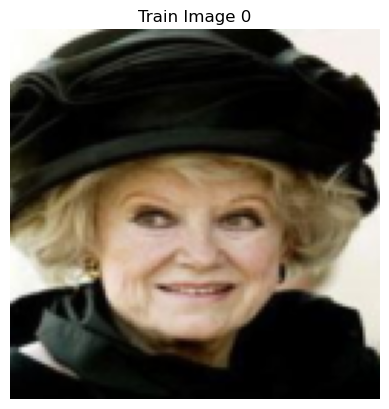

In [71]:
plot_image_from_dataset(test_dataset, 0)

In [115]:
# Attribute dataframe for test image 1
import pandas as pd
df = pd.DataFrame({
    'Attribute': attribute_names,
    'True Value': test_dataset[0][1].numpy().astype(bool),
    'Predicted Value': test_preds[0].numpy().astype(bool)
})
df

,Attribute,True Binary Value,Predicted Binary Value
0,5_o_Clock_Shadow,False,False
1,Arched_Eyebrows,True,False
2,Attractive,False,True
3,Bags_Under_Eyes,True,False
4,Bald,False,False
5,Bangs,False,False
6,Big_Lips,False,False
7,Big_Nose,False,True
8,Black_Hair,False,False
9,Blond_Hair,False,False


In [72]:
# Nearest neighbors of test image
query_attr = test_dataset[0][1].numpy().reshape(1, -1)  # Convert to numpy array (1, 40)

# Get top 5 nearest neighbots
distances, indices = knn.kneighbors(query_attr, n_neighbors=5)
print(f"Indices of closest images: {indices}")

Indices of closest images: [[182637  39821 161370  29605  19335]]


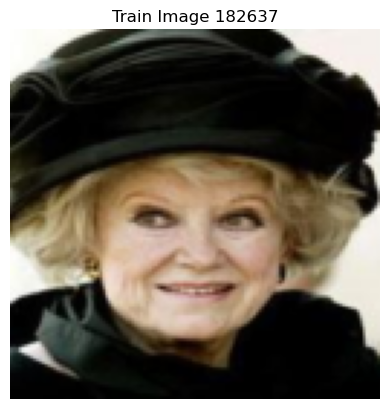

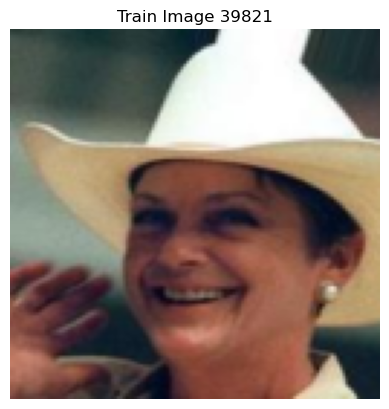

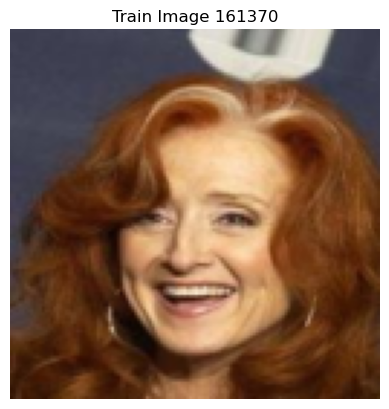

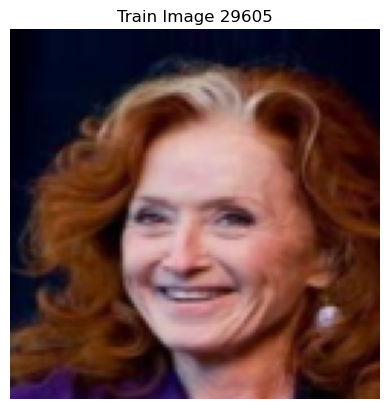

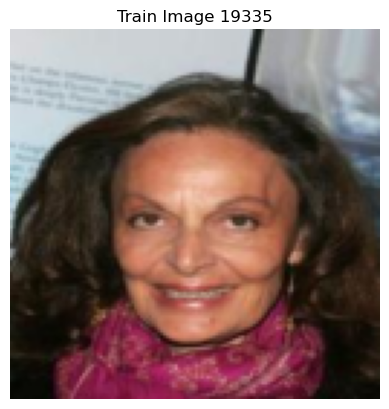

In [73]:
# Plot top 3 matches
for i in indices[0]:
    plot_image_from_dataset(combined_dataset, i)

#### Predict on same test image, then match nearest neighbors

In [79]:
# Accuracy between ground truth and predictions for image 0
(test_preds[0] == test_dataset[0][1]).sum() / 40

tensor(0.8250)

In [85]:
# Prediction for test image 0
query_attr = test_preds[0].numpy().reshape(1, -1)  # Convert to numpy array (1, 40)

# Get top 5 nearest neighbots
distances, indices = knn.kneighbors(query_attr, n_neighbors=5)
print(f"Indices of closest images: {indices}")

Indices of closest images: [[158150 167548  40445   2215  37192]]


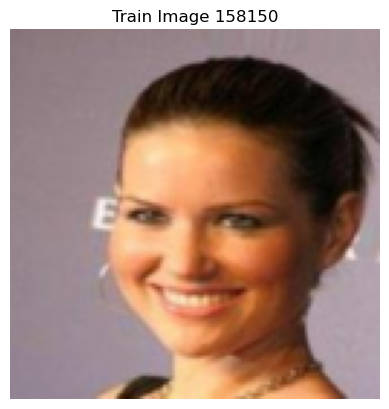

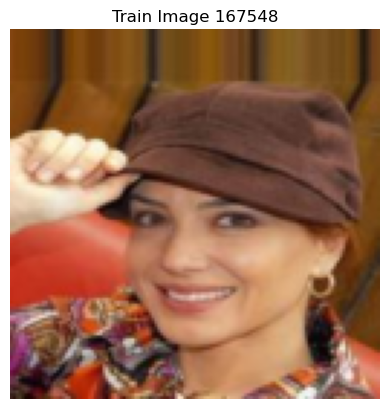

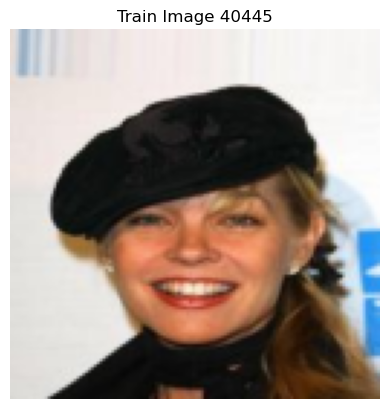

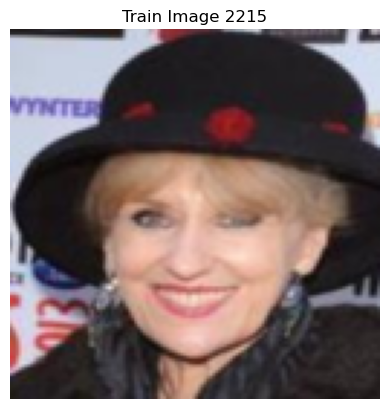

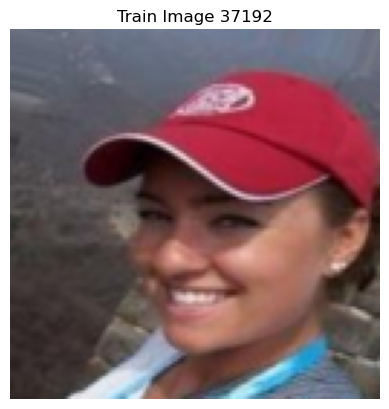

In [86]:
# Plot top 3 matches
for i in indices[0]:
    plot_image_from_dataset(combined_dataset, i)

#### Predict on new Adam Brody image

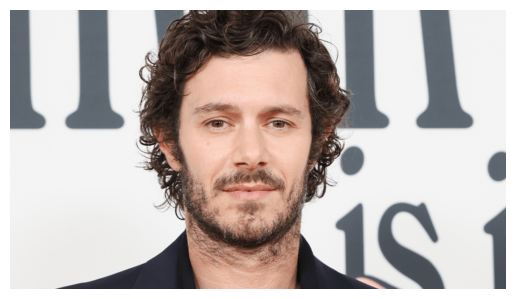

In [89]:
from PIL import Image
# Same transformation as celebA dataset
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
image_path = "adam_brody.png"
image = Image.open(image_path).convert("RGB")
plt.imshow(image)
plt.axis("off")
plt.show()
input_tensor = transform(image).unsqueeze(0)

model.eval()
with torch.no_grad():
    output = model(input_tensor)         # shape: [1, 40]
    adam_pred = (output >= 0.5).float() 

In [90]:
adam_pred

tensor([[0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.]])

In [91]:
# Adam Brody KNN
query_attr = adam_pred.numpy().reshape(1, -1)  # Convert to numpy array (1, 40)

# Get top 5 nearest neighbots
distances, indices = knn.kneighbors(query_attr, n_neighbors=5)
print(f"Indices of closest images: {indices}")

Indices of closest images: [[ 61955  63023 171858  89360 141604]]


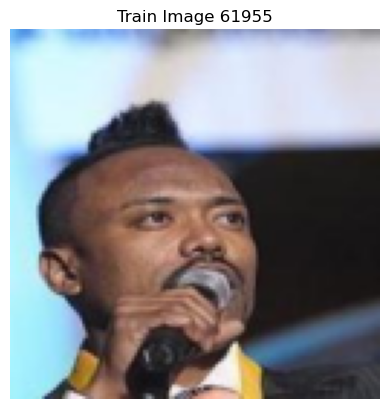

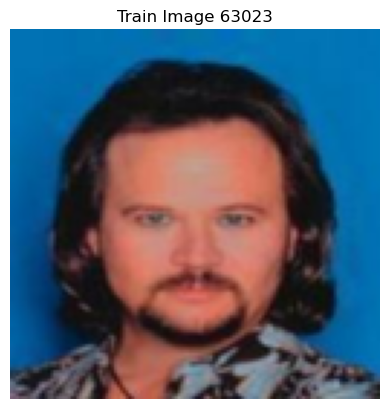

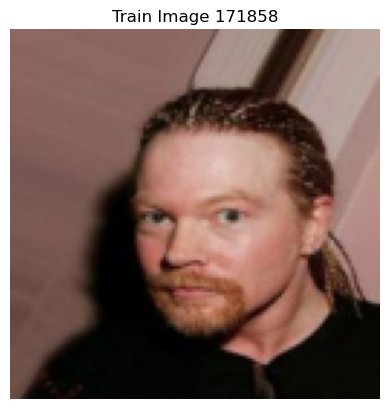

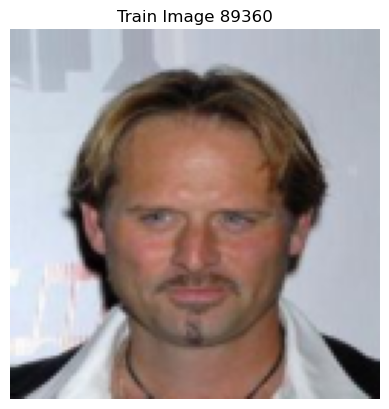

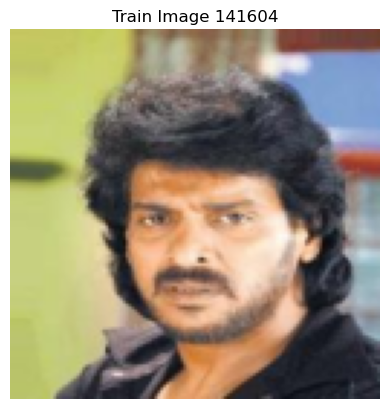

In [92]:
# Plot top 3 matches
for i in indices[0]:
    plot_image_from_dataset(combined_dataset, i)

In [96]:
# Accuracy between adam's prediction and nearest neighbor
(adam_pred == combined_dataset[61955][1]).sum() / 40

tensor(1.)

In [112]:
adam_pred[0]

tensor([0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0.])

In [116]:
# Attribute dataframe for adam brody prediction
import pandas as pd
df = pd.DataFrame({
    'Attribute': attribute_names,
    'Predicted Value': adam_pred[0].numpy().astype(bool)
})
df

,Attribute,Predicted Value
0,5_o_Clock_Shadow,False
1,Arched_Eyebrows,False
2,Attractive,False
3,Bags_Under_Eyes,False
4,Bald,False
5,Bangs,False
6,Big_Lips,False
7,Big_Nose,True
8,Black_Hair,True
9,Blond_Hair,False
